In [3]:
# Configuring libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn import metrics

%matplotlib inline

In [4]:
# Reading the data

df = pd.read_csv('train.csv', index_col = 0)
df.head()

,day,hour,geohash,n.total,n.uber,n.bike,n.green,n.yellow,lat,long,...,state,borough,hour.num,hour.cos,hour.sin,wday.num,wday.cos,wday.sin,prec.cat,log.total
1,1,0,dr5qu,4,0,0,3,1,40.583496,-73.981934,...,New York,Kings County,0.0,1.0,0.0,0.285714,-0.222521,0.974928,"(-Inf,0]",2.386294
2,1,0,dr5qv,4,0,0,4,0,40.583496,-73.937988,...,New York,Kings County,0.0,1.0,0.0,0.285714,-0.222521,0.974928,"(-Inf,0]",2.386294
3,1,0,dr5r5,7,1,0,5,1,40.627441,-74.025879,...,New York,Kings County,0.0,1.0,0.0,0.285714,-0.222521,0.974928,"(-Inf,0]",2.945910
4,1,0,dr5r7,1,0,0,0,1,40.671387,-74.025879,...,New York,NaN,0.0,1.0,0.0,0.285714,-0.222521,0.974928,"(-Inf,0]",1.000000
5,1,0,dr5re,672,15,7,0,650,40.715332,-74.025879,...,New York,NaN,0.0,1.0,0.0,0.285714,-0.222521,0.974928,"(-Inf,0]",7.510258


In [5]:
# Preparing training and testing data

y = np.log10(df['n.total']+1)
X = df[['day', 'hour', 'lat', 'long', 'wknd', 'mean_temp', 'hour.num', 'hour.cos', 'hour.sin', 
        'wday.num', 'wday.cos', 'wday.sin', 'precip_sum']]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

### Tuning hyperparameter k via gridsearch

In [7]:

# Pipeline: sequentially applying standardization and a knnReg estimator 
# StandardScaler: standardizing features by removing the mean and scaling to unit variance
# GridSearch: defining a grid of parameters over which to optimize the knn regressor

pipe_knn = Pipeline([('scl', StandardScaler()), ('reg', KNeighborsRegressor())])
param_range = [1,2,3,4,5,6,7,8,9]
params = [{'reg__n_neighbors': param_range}]

gs = GridSearchCV(estimator = pipe_knn, 
                  param_grid = params, 
                  scoring = ('neg_mean_squared_error'), 
                  cv =10, 
                  n_jobs = -1)
gs = gs.fit(X_train, y_train)

print('Best MSE: %.3f' %gs.best_score_)
print(gs.best_params_)

Best MSE: -0.163
{'reg__n_neighbors': 1}


In [39]:
print(gs.best_estimator_)
print(gs.best_params_)

Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='uniform'))])
{'reg__n_neighbors': 1}


In [40]:
knn_b = gs.best_estimator_
knn_b.fit(X_train, y_train)
print('R-Squared: %.5f' %knn_b.score(X_test, y_test))

R-Squared: 0.88061


In [41]:
knn_b.fit(X_train, y_train)

Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='uniform'))])

In [42]:
predictions_b = knn_b.predict(X_test)

In [43]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions_b))
print('MSE:', metrics.mean_squared_error(y_test, predictions_b))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions_b)))
print('RSquared', metrics.explained_variance_score(y_test, predictions_b))

MAE: 0.200695830246
MSE: 0.123668544748
RMSE: 0.351665387475
RSquared 0.880616537786


### Training the 'best' kNN Regression model

In [14]:
# fitting the standardscaler only once on the training data and using 
# those parameters to transform the test set or any new data point

scaler = StandardScaler()

scaler.fit_transform(X)
scaled_features = scaler.transform(X)

In [15]:
knn = KNeighborsRegressor(n_neighbors = 1)

In [16]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(scaled_features, y, test_size=0.30)

In [18]:
knn.fit(X_train_s, y_train_s)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='uniform')

### Prediction and Evaluation

In [19]:
predictions = knn.predict(X_test_s)

In [24]:
# Show some of the predictions vs. real number of trips
pd.DataFrame(np.round(np.power(10, np.column_stack((predictions, y_test_s))) - 1, decimals = 0).astype(int)).head() 

,0,1
0,5,10
1,7038,12990
2,394,451
3,220,230
4,2222,2551


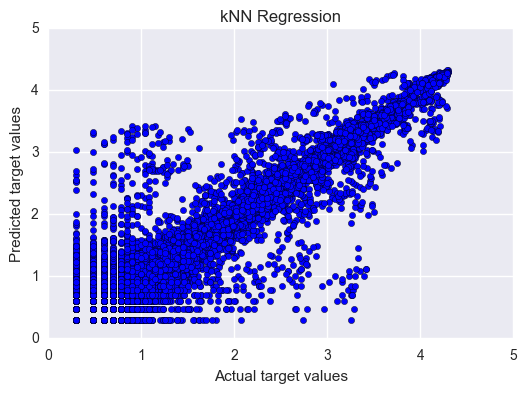

In [45]:
# Scatterplot of real test values vs. predicted ones
plt.scatter(y_test_s, predictions)
plt.title('kNN Regression')
plt.xlabel('Actual target values')
plt.ylabel('Predicted target values')
plt.savefig('knn.png')

(array([  3.00000000e+00,   0.00000000e+00,   7.00000000e+00,
          8.00000000e+00,   1.00000000e+01,   1.10000000e+01,
          7.00000000e+00,   1.00000000e+01,   1.00000000e+01,
          1.00000000e+01,   1.40000000e+01,   1.70000000e+01,
          2.10000000e+01,   2.80000000e+01,   3.10000000e+01,
          4.20000000e+01,   7.20000000e+01,   9.50000000e+01,
          1.34000000e+02,   1.98000000e+02,   3.16000000e+02,
          7.27000000e+02,   9.69000000e+02,   3.07700000e+03,
          5.27700000e+03,   2.83000000e+03,   1.64100000e+03,
          8.11000000e+02,   3.29000000e+02,   1.80000000e+02,
          1.11000000e+02,   6.90000000e+01,   5.10000000e+01,
          3.30000000e+01,   2.00000000e+01,   2.00000000e+01,
          2.50000000e+01,   1.40000000e+01,   1.50000000e+01,
          6.00000000e+00,   3.00000000e+00,   2.00000000e+00,
          3.00000000e+00,   7.00000000e+00,   5.00000000e+00,
          7.00000000e+00,   6.00000000e+00,   0.00000000e+00,
        

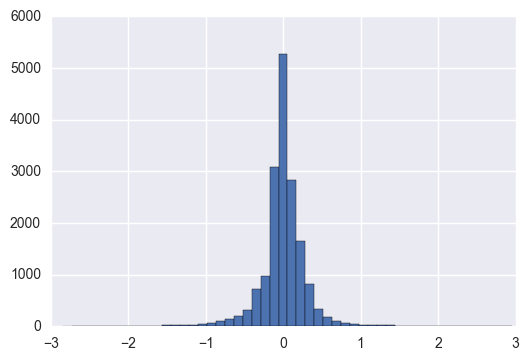

In [27]:
# Plotting a histogram of the residuals - are they normally distributed?
plt.hist((y_test_s-predictions), bins = 50)

### Analyzing the results

In [30]:
print('MAE:', metrics.mean_absolute_error(y_test_s, predictions))
print('MSE:', metrics.mean_squared_error(y_test_s, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_s, predictions)))
print('RSquared', metrics.explained_variance_score(y_test_s, predictions))

MAE: 0.196795865897
MSE: 0.116021685349
RMSE: 0.34061956102
RSquared 0.887345548795


In [33]:
RMSE = []

# Will take some time
for i in range(1,10):
    
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train_s,y_train_s)
    pred_i = knn.predict(X_test_s)
    RMSE.append(np.sqrt(metrics.mean_squared_error(y_test_s, pred_i)))

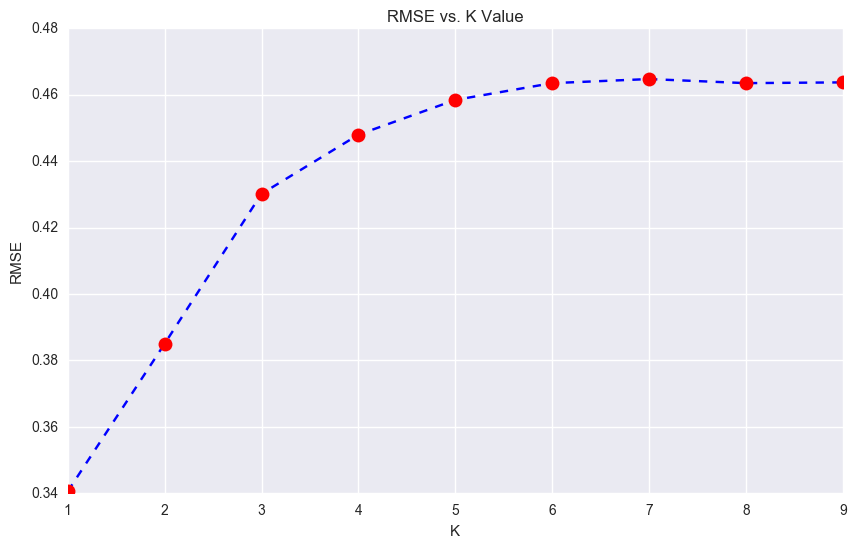

In [34]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10),RMSE,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('RMSE vs. K Value')
plt.xlabel('K')
plt.ylabel('RMSE')

### Computing evaluation metrics using 10-fold cross validation

In [36]:
# Creating dataset to be used for CV
df1 = df[['day', 'hour', 'lat', 'long', 'wknd', 'mean_temp', 'hour.num', 'hour.cos', 'hour.sin', 
        'wday.num', 'wday.cos', 'wday.sin', 'precip_sum']]
df1['log.total'] = np.log10(df['n.total'] + 1)
array = df1.values

# Defining target and feature variables
X = array[:,0:13]
y = array[:,13]

# Standardize X
scaler.fit_transform(X)
sf = scaler.transform(X) # scaled features


# Computing RMSE and RSquared using 10-fold cross validation 
kf = KFold(n_splits = 10)
for train, test in kf.split(sf):
    knn.fit(sf[train], y[train])
    p = knn.predict(sf[test])

rmse_10cv = np.sqrt(metrics.mean_squared_error(y[test], p))
r2_10cv = metrics.explained_variance_score(y[test], p)


print ('RSquared on 10-fold CV: %.4f' %r2_10cv)
print ('RMSE on 10-fold CV: %.4f' %rmse_10cv)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RSquared on 10-fold CV: 0.8794
RMSE on 10-fold CV: 0.3510
